In [1]:
path_data = '../01 data/'
epochs=50
batch_size=200
monitor = 'accuracy'
mode = 'max'
patience = 10
test_score, val_score = 'accuracy', 'val_accuracy'

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data preparation

In [3]:
# Load data
trainSet = pd.read_csv(path_data + 'train.csv')
testSet = pd.read_csv(path_data + 'test.csv')
print(trainSet.shape)
trainSet.head()

(100000, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [44]:
trainSet['Survived'].value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

In [14]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [5]:
# Feature generation: training data
train = trainSet.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
train = pd.get_dummies(train)


# Feature generation: test data
test = testSet.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test['Age'] = test['Age'].fillna(train['Age'].median())
test['Fare'] = test['Fare'].fillna(train['Fare'].median())
test = pd.get_dummies(test)

print(train.shape)
train.head()

(100000, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,1,39.00,2,0,27.14,0,1,0,0,1
1,0,3,39.00,0,0,13.35,0,1,0,0,1
2,0,3,0.33,1,2,71.29,0,1,0,0,1
3,0,3,19.00,0,0,13.04,0,1,0,0,1
4,1,3,25.00,0,0,7.76,0,1,0,0,1


In [9]:
# train validation split
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns=['Survived']),
    train['Survived'],
    test_size=0.2,
    random_state=123
)

In [10]:
X_train.to_csv('../03 outputs/01/X_train.csv', index=False)
X_val.to_csv('../03 outputs/01/X_val.csv', index=False)
y_train.to_csv('../03 outputs/01/y_train.csv', index=False)
y_val.to_csv('../03 outputs/01/y_val.csv', index=False)
test.to_csv('../03 outputs/01/test.csv', index=False)

# Training models

In [29]:
def build_model(n_output_class):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2, seed=123))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(n_output_class, activation='sigmoid')) # or softmax
    opt = Adam(learning_rate=1e-3)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # If binary
    # model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # If multi-class

    return model

In [12]:
# Set callbacks
def create_callbacks(model_name, monitor, mode, patience):
    # Early stopping
    es = EarlyStopping(
        monitor=monitor, mode=mode, verbose=0, patience=patience, restore_best_weights=True
    )

    # Checkpoint
    checkpoint = ModelCheckpoint(
        filepath=model_name,
        monitor=monitor,
        mode=mode,
        save_best_only=True
    )

    return es, checkpoint

In [27]:
# Fit model
def fit_model(model, es, checkpoint):
    model_history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, es],
        verbose=1,
    )
    return model, model_history

In [14]:
# Plot model history
def plot_history(model_history, test_score, val_score):
    # Visualize the CNN training history
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    # Accuracy
    ax[0].plot(model_history.history[test_score])
    ax[0].plot(model_history.history[val_score])
    ax[0].set_title(test_score)
    ax[0].set_ylabel(test_score)
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    # Loss
    ax[1].plot(model_history.history['loss'])
    ax[1].plot(model_history.history['val_loss'])
    ax[1].set_title('loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()

In [30]:
# Create callbacks
es, checkpoint = create_callbacks('../03 outputs/01/classification_model.hdf5', monitor, mode, patience)
# Build model architecture
model = build_model(n_output_class=1)
# Fit the model
model, model_history = fit_model(model, es, checkpoint)

Epoch 1/50
400/400 [==============================] - 2s 3ms/step - loss: 0.5582 - accuracy: 0.7155 - val_loss: 0.5094 - val_accuracy: 0.7594
Epoch 2/50
 53/400 [==>...........................] - ETA: 0s - loss: 0.5113 - accuracy: 0.7609

c:\Users\Danamas\anaconda3\envs\venv_38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - 1s 3ms/step - loss: 0.5094 - accuracy: 0.7624 - val_loss: 0.5106 - val_accuracy: 0.7607
Epoch 3/50
400/400 [==============================] - 1s 3ms/step - loss: 0.5062 - accuracy: 0.7649 - val_loss: 0.4984 - val_accuracy: 0.7645
Epoch 4/50
400/400 [==============================] - 1s 3ms/step - loss: 0.5041 - accuracy: 0.7653 - val_loss: 0.4977 - val_accuracy: 0.7686
Epoch 5/50
400/400 [==============================] - 1s 3ms/step - loss: 0.5015 - accuracy: 0.7670 - val_loss: 0.4981 - val_accuracy: 0.7645
Epoch 6/50
400/400 [==============================] - 1s 3ms/step - loss: 0.5010 - accuracy: 0.7667 - val_loss: 0.4975 - val_accuracy: 0.7688
Epoch 7/50
400/400 [==============================] - 1s 2ms/step - loss: 0.5008 - accuracy: 0.7669 - val_loss: 0.4960 - val_accuracy: 0.7678
Epoch 8/50
400/400 [==============================] - 1s 3ms/step - loss: 0.4995 - accuracy: 0.7677 - val_loss: 0.4998 - val_accuracy: 0.7663
Epoch 9/50
400/40

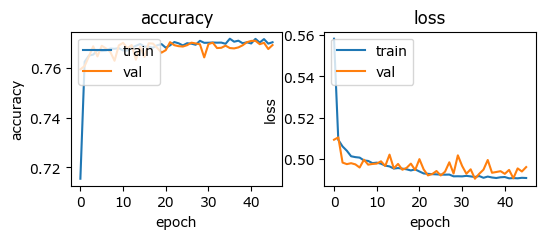

In [31]:
# Plot model history
plot_history(model_history, test_score, val_score)

# Invoke prediction

In [41]:
# Train
pred_train = pd.DataFrame(y_train)
pred_train['prob'] = model.predict(X_train)
pred_train.columns = ['true', 'prob']
pred_train['prob'] = round(pred_train['prob'], 3)
pred_train['pred'] = (round(pred_train['prob'], 0)).astype(int)

# Val
pred_val = pd.DataFrame(y_val)
pred_val['prob'] = model.predict(X_val)
pred_val.columns = ['true', 'prob']
pred_val['prob'] = round(pred_val['prob'], 3)
pred_val['pred'] = (round(pred_val['prob'], 0)).astype(int)

# Test
pred_test = model.predict(test)
pred_test = pd.DataFrame(pred_test)
pred_test.columns = ['prob']
pred_test['prob'] = round(pred_test['prob'], 3)
pred_test['pred'] = (round(pred_test['prob'], 0)).astype(int)

pred_train.head(3)

3125/3125 [==============================] - 4s 1ms/step


,true,prob,pred
22302,1,0.229,0
49609,0,0.121,0
89251,0,0.111,0


In [47]:
y_train.value_counts()

0    45748
1    34252
Name: Survived, dtype: int64

In [43]:
# Model evaluation
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_train, pred_train['pred']), index=[0,1], columns=[0,1]))
print('')
print('Classification Report')
print(classification_report(y_train, pred_train['pred']))

Confusion Matrix
       0      1
0  36283   9465
1   8813  25439

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     45748
           1       0.73      0.74      0.74     34252

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000



In [45]:
# Model evaluation
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_val, pred_val['pred']), index=[0,1], columns=[0,1]))
print('')
print('Classification Report')
print(classification_report(y_val, pred_val['pred']))

Confusion Matrix
      0     1
0  9066  2412
1  2228  6294

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     11478
           1       0.72      0.74      0.73      8522

    accuracy                           0.77     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.77      0.77      0.77     20000



In [46]:
# Save
pred_train.to_csv('../03 outputs/01/pred_train.csv')
pred_val.to_csv('../03 outputs/01/pred_val.csv')
pred_test.to_csv('../03 outputs/01/pred_test.csv')